In this notebook we will describe different strategies of algotrading, such as:
- Mean Reversion
- Tendency Following
- Statistical Arbitrage

And also we will compare them with each other from the starting of trading on this instrument. With comparison for each year and for the whole period.

For start we will have 100 USDT on our account and we will add 100 USDT every month. We will trade only on BTCUSDT pair. Standart strategy will be buy and hold. We will compare our strategies with it and with invested capital.

Load libraries and data

In [76]:
# Little help
import warnings
warnings.filterwarnings('ignore')

In [77]:
import pandas as pd
from typing import Dict

data: pd.DataFrame = pd.read_csv("C:/Users/Admin/PycharmProjects/GarbageCollector/data/BTCUSDT/BTCUSDT-1h.csv")

data.head()

,open_time,open,high,low,close,volume,num_trades,taker_base_vol
0,1502942400000,4261.48,4313.62,4261.32,4308.83,47.181009,171,35.160503
1,1502946000000,4308.83,4328.69,4291.37,4315.32,23.234916,102,21.448071
2,1502949600000,4330.29,4345.45,4309.37,4324.35,7.229691,36,4.802861
3,1502953200000,4316.62,4349.99,4287.41,4349.99,4.443249,25,2.602292
4,1502956800000,4333.32,4377.85,4333.32,4360.69,0.972807,28,0.814655


In [78]:
# Unix time to datetime
data["open_time"] = pd.to_datetime(data["open_time"], unit="ms")

In [79]:
min_date = data["open_time"].min()
max_date = data["open_time"].max()
print(f"Min date: {min_date}")
print(f"Max date: {max_date}")

Min date: 2017-08-17 04:00:00
Max date: 2023-12-10 12:00:00


In [80]:
every_month_capital = pd.DataFrame(columns=["date", "invested", "BTC_Price", "buy_and_hold_BTC", "buy_and_hold_USDT", "mean_reversion", "tendency_following", "statistical_arbitrage"])

In [81]:
# Set date column
every_month_capital["date"] = pd.date_range(start=min_date, end=max_date, freq="MS")

In [82]:
# Set invested column (every first day of month we add 100 USDT)
every_month_capital["invested"] = every_month_capital.index.map(lambda x: 100 * (x + 1))

In [83]:
# Set buy_and_hold column
def get_price(date: pd.Timestamp) -> float:
    return data[data["open_time"] == date]["close"].values[0]

# BTC Price
every_month_capital["BTC_Price"] = every_month_capital["date"].map(lambda x: get_price(x))

# Capital in BTC
every_month_capital["buy_and_hold_BTC"] = every_month_capital["BTC_Price"].map(lambda x: 100 / x)
every_month_capital["buy_and_hold_BTC"] = every_month_capital["buy_and_hold_BTC"].cumsum()

# Capital in USDT
every_month_capital["buy_and_hold_USDT"] = every_month_capital["buy_and_hold_BTC"] * every_month_capital["BTC_Price"]

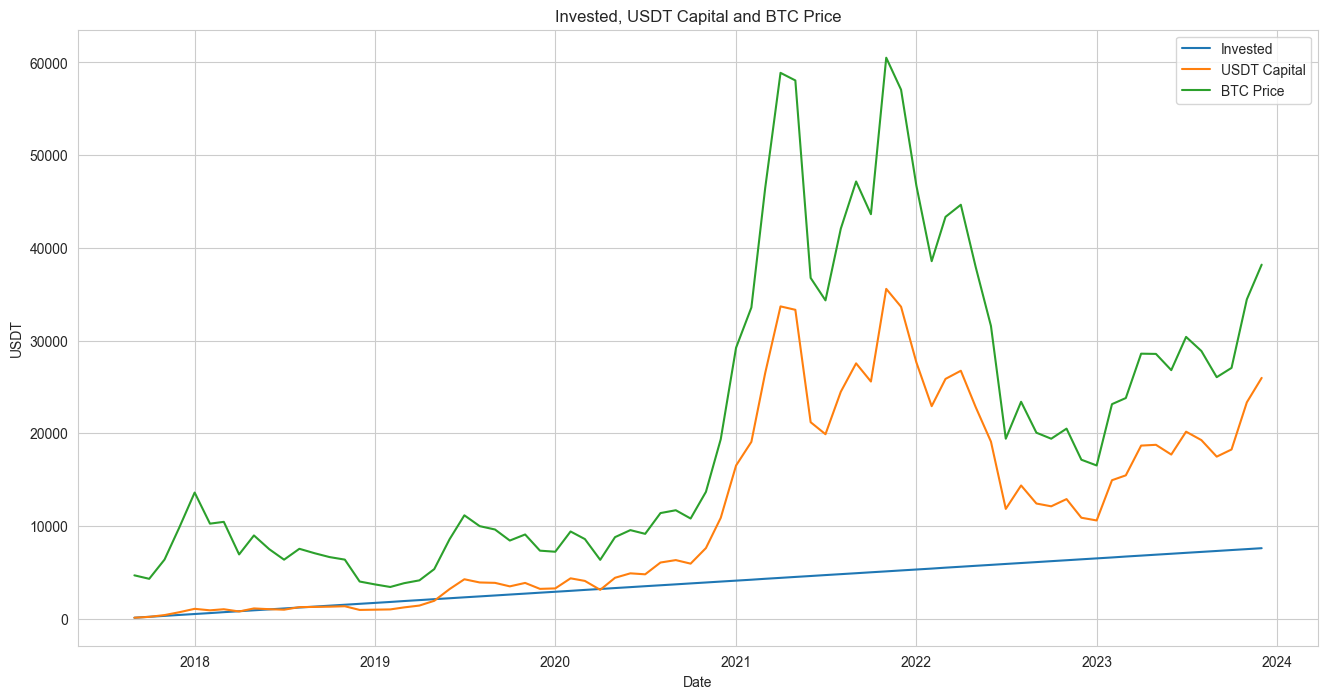

In [84]:
# Let's build a graph on invested, buy_and_hold_USDT and BTC_Price
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(every_month_capital["date"], every_month_capital["invested"], label="Invested")
ax.plot(every_month_capital["date"], every_month_capital["buy_and_hold_USDT"], label="USDT Capital")
ax.plot(every_month_capital["date"], every_month_capital["BTC_Price"], label="BTC Price")

ax.set_title("Invested, USDT Capital and BTC Price")
ax.set_xlabel("Date")
ax.set_ylabel("USDT")
ax.legend()
plt.show()

In [85]:
every_month_capital.tail()

,date,invested,BTC_Price,buy_and_hold_BTC,buy_and_hold_USDT,mean_reversion,tendency_following,statistical_arbitrage
71,2023-08-01 04:00:00,7200,28866.00,0.667086,19256.094490,NaN,NaN,NaN
72,2023-09-01 04:00:00,7300,26044.46,0.670925,17473.885633,NaN,NaN,NaN
73,2023-10-01 04:00:00,7400,27045.47,0.674623,18245.488510,NaN,NaN,NaN
74,2023-11-01 04:00:00,7500,34439.57,0.677526,23333.716357,NaN,NaN,NaN
75,2023-12-01 04:00:00,7600,38179.86,0.680146,25967.861411,NaN,NaN,NaN


As we see, sometimes we have a drawdown even under investments, but in general, the strategy is profitable. At the end of the period we have totally invested 7600 USDT (it is 0.68 BTC) and capital worth at 25967 USDT. It is 3.4 times more than we invested. 241% profit for 6 years. If we take complex interest rate, it is ~ 22.68% per year. Not bad, we are higher than S&P 500. Let's see how our strategies will behave.

## Mean Reversion and Tendency Following

### Description

Mean reversion is a theory used in finance that suggests that asset prices and historical returns eventually will revert to the long-run mean or average level of the entire dataset. This mean can pertain to another relevant average, such as economic growth or the average return of an industry.

## How we will trade
We have indicator SMA, which is simple moving average. We will use it to determine the trend. If the price is above SMA, we will sell BTC and buy USDT. If the price is below SMA, we will sell USDT and buy BTC. We will choose the best strategy of three:
1) SMA with period 20
2) SMA with period 50
3) Buy on SMA 20 cross SMA 50 and sell on SMA 50 cross SMA 20 - tendecy following


In [86]:
data_sma = data.copy()

data_sma["SMA_20"] = data_sma["close"].rolling(20).mean()
data_sma["SMA_50"] = data_sma["close"].rolling(50).mean()

data_sma.head(50)

,open_time,open,high,low,close,volume,num_trades,taker_base_vol,SMA_20,SMA_50
0,2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009,171,35.160503,NaN,NaN
1,2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916,102,21.448071,NaN,NaN
2,2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691,36,4.802861,NaN,NaN
3,2017-08-17 07:00:00,4316.62,4349.99,4287.41,4349.99,4.443249,25,2.602292,NaN,NaN
4,2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807,28,0.814655,NaN,NaN
5,2017-08-17 09:00:00,4360.00,4445.78,4360.00,4444.00,10.763623,43,10.258400,NaN,NaN
6,2017-08-17 10:00:00,4441.10,4470.00,4399.81,4460.00,24.865399,82,21.698693,NaN,NaN
7,2017-08-17 11:00:00,4460.00,4485.39,4427.30,4427.30,27.018053,95,26.015885,NaN,NaN
8,2017-08-17 12:00:00,4436.06,4449.56,4411.00,4411.00,23.032398,108,15.312994,NaN,NaN
9,2017-08-17 13:00:00,4411.00,4459.00,4411.00,4459.00,31.312436,118,26.564042,NaN,NaN


In [87]:
# Prepare data for backtesting
data_sma.drop(columns=["open", "high", "low", "volume", "num_trades", "taker_base_vol"], inplace=True)

In [88]:
# Add column with invested capital every month (100 USDT)
data_sma["invested"] = data_sma["open_time"].map(lambda x: 100 if x.day == 1 and x.hour==0 else 0)
data_sma["invested"] = data_sma["invested"].cumsum()

In [89]:
data_sma.head()

,open_time,close,SMA_20,SMA_50,invested
0,2017-08-17 04:00:00,4308.83,NaN,NaN,0
1,2017-08-17 05:00:00,4315.32,NaN,NaN,0
2,2017-08-17 06:00:00,4324.35,NaN,NaN,0
3,2017-08-17 07:00:00,4349.99,NaN,NaN,0
4,2017-08-17 08:00:00,4360.69,NaN,NaN,0


In [90]:
from tqdm import tqdm

data_sma["ST1_money"] = 0
data_sma["ST1_BTC"] = 0
data_sma["ST1_capital"] = 0

data_sma["ST2_money"] = 0
data_sma["ST2_BTC"] = 0
data_sma["ST2_capital"] = 0

data_sma["ST3_money"] = 0
data_sma["ST3_BTC"] = 0
data_sma["ST3_capital"] = 0

for i, row in tqdm(data_sma.iterrows(), total=data_sma.shape[0]):
    # Add money every month
    if row["open_time"].day == 1 and row["open_time"].hour == 1:
        data_sma.loc[i, "ST1_money"] = data_sma.loc[i-1, "ST1_money"] + 100
        data_sma.loc[i, "ST2_money"] = data_sma.loc[i-1, "ST2_money"] + 100
        data_sma.loc[i, "ST3_money"] = data_sma.loc[i-1, "ST3_money"] + 100
    else:
        if i > 0:
            data_sma.loc[i, "ST1_money"] = data_sma.loc[i-1, "ST1_money"]
            data_sma.loc[i, "ST2_money"] = data_sma.loc[i-1, "ST2_money"]
            data_sma.loc[i, "ST3_money"] = data_sma.loc[i-1, "ST3_money"]
        else:
            data_sma.loc[i, "ST1_money"] = 0
            data_sma.loc[i, "ST2_money"] = 0
            data_sma.loc[i, "ST3_money"] = 0
    
    if i > 0:
        data_sma.loc[i, "ST1_BTC"] = data_sma.loc[i-1, "ST1_BTC"]
        data_sma.loc[i, "ST2_BTC"] = data_sma.loc[i-1, "ST2_BTC"]
        data_sma.loc[i, "ST3_BTC"] = data_sma.loc[i-1, "ST3_BTC"]
    else:
        data_sma.loc[i, "ST1_BTC"] = 0
        data_sma.loc[i, "ST2_BTC"] = 0
        data_sma.loc[i, "ST3_BTC"] = 0
    
    # ST1: Buy if price is below SMA_20 and sell if price is above SMA_20
    if row["SMA_20"] > 0:
        if row["SMA_20"] < row["close"]:
            # Sell BTC and buy USDT
            if data_sma.loc[i, "ST1_BTC"] > 0:
                data_sma.loc[i, "ST1_money"] += data_sma.loc[i-1, "ST1_BTC"] * row["close"]
                data_sma.loc[i, "ST1_BTC"] = 0
        else:
            # Sell USDT and buy BTC
            if data_sma.loc[i, "ST1_money"] > 0:
                data_sma.loc[i, "ST1_BTC"] += data_sma.loc[i-1, "ST1_money"] / row["close"]
                data_sma.loc[i, "ST1_money"] = 0
    
    data_sma.loc[i, "ST1_capital"] = data_sma.loc[i, "ST1_money"] + data_sma.loc[i, "ST1_BTC"] * row["close"]
             
    # ST2: Buy if price is below SMA_50 and sell if price is above SMA_50
    if row["SMA_50"] > 0:
        if row["SMA_50"] < row["close"]:
            # Sell BTC and buy USDT
            if data_sma.loc[i, "ST2_BTC"] > 0:
                data_sma.loc[i, "ST2_money"] += data_sma.loc[i-1, "ST2_BTC"] * row["close"]
                data_sma.loc[i, "ST2_BTC"] = 0
        else:
            # Sell USDT and buy BTC
            if data_sma.loc[i, "ST2_money"] > 0:
                data_sma.loc[i, "ST2_BTC"] += data_sma.loc[i-1, "ST2_money"] / row["close"]
                data_sma.loc[i, "ST2_money"] = 0
                
    data_sma.loc[i, "ST2_capital"] = data_sma.loc[i, "ST2_money"] + data_sma.loc[i, "ST2_BTC"] * row["close"]
    
    # ST3: Buy if SMA_20 cross SMA_50 and sell if SMA_50 cross SMA_20
    if row["SMA_20"] > 0 and row["SMA_50"] > 0:
        if row["SMA_20"] < row["SMA_50"]:
            # Sell BTC and buy USDT
            if data_sma.loc[i, "ST3_BTC"] > 0:
                data_sma.loc[i, "ST3_money"] += data_sma.loc[i-1, "ST3_BTC"] * row["close"]
                data_sma.loc[i, "ST3_BTC"] = 0
        else:
            # Sell USDT and buy BTC
            if data_sma.loc[i, "ST3_money"] > 0:
                data_sma.loc[i, "ST3_BTC"] += data_sma.loc[i-1, "ST3_money"] / row["close"]
                data_sma.loc[i, "ST3_money"] = 0
    
    data_sma.loc[i, "ST3_capital"] = data_sma.loc[i, "ST3_money"] + data_sma.loc[i, "ST3_BTC"] * row["close"]

100%|██████████| 55225/55225 [00:42<00:00, 1290.00it/s]


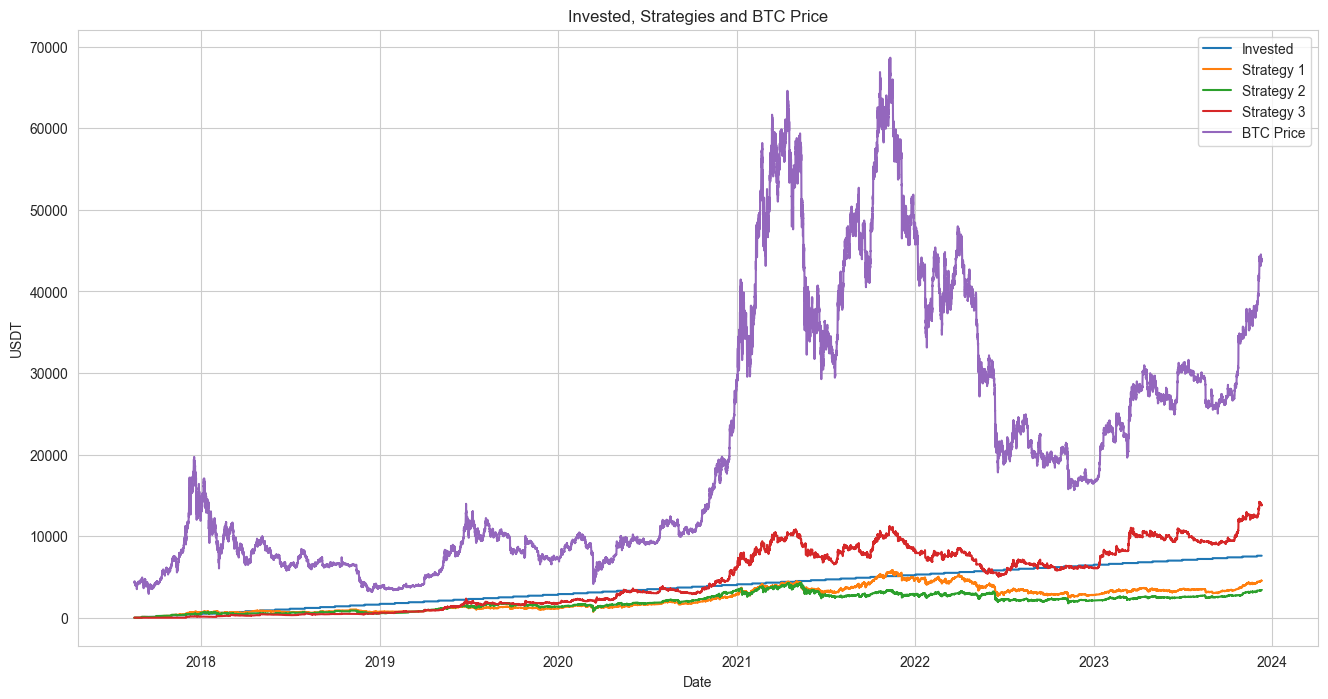

In [91]:
# Let's build a graph on invested, ST1_capital, ST2_capital, ST3_capital and BTC_Price
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(data_sma["open_time"], data_sma["invested"], label="Invested")
ax.plot(data_sma["open_time"], data_sma["ST1_capital"], label="Strategy 1")
ax.plot(data_sma["open_time"], data_sma["ST2_capital"], label="Strategy 2")
ax.plot(data_sma["open_time"], data_sma["ST3_capital"], label="Strategy 3")
ax.plot(data_sma["open_time"], data_sma["close"], label="BTC Price")

ax.set_title("Invested, Strategies and BTC Price")
ax.set_xlabel("Date")
ax.set_ylabel("USDT")
ax.legend()
plt.show()

In [92]:
data_sma.tail()

,open_time,close,SMA_20,SMA_50,invested,ST1_money,ST1_BTC,ST1_capital,ST2_money,ST2_BTC,ST2_capital,ST3_money,ST3_BTC,ST3_capital
55220,2023-12-10 08:00:00,43775.51,43899.7020,43896.8496,7600,0.0,0.103654,4537.496806,0.0,0.077642,3398.803481,0.00000,0.315687,13819.360066
55221,2023-12-10 09:00:00,43606.80,43880.2255,43905.6654,7600,0.0,0.103654,4520.009378,0.0,0.077642,3385.704556,13766.10051,0.000000,13766.100510
55222,2023-12-10 10:00:00,43700.02,43868.4475,43915.4070,7600,0.0,0.103654,4529.671983,0.0,0.077642,3392.942312,13766.10051,0.000000,13766.100510
55223,2023-12-10 11:00:00,43738.02,43853.0935,43927.4478,7600,0.0,0.103654,4533.610826,0.0,0.077642,3395.892695,13766.10051,0.000000,13766.100510
55224,2023-12-10 12:00:00,43740.44,43839.6865,43935.2568,7600,0.0,0.103654,4533.861668,0.0,0.077642,3396.080588,13766.10051,0.000000,13766.100510


As we see 3rd strategy is the best. Let's add it to our dataframe with capital

In [93]:
for i, row in tqdm(every_month_capital.iterrows(), total=every_month_capital.shape[0]):
    date = row["date"]
    capital1 = data_sma[data_sma["open_time"] == date]["ST1_capital"].values[0]
    capital2 = data_sma[data_sma["open_time"] == date]["ST3_capital"].values[0]
    every_month_capital.loc[i, "mean_reversion"] = capital1
    every_month_capital.loc[i, "tendency_following"] = capital2

100%|██████████| 76/76 [00:00<00:00, 950.02it/s]


## Statistical Arbitrage

### Description

For this strategy we will use another pair. We will use BTCUSDT and ETHUSDT. We will trade on BTCUSDT pair. If the price of BTCUSDT is higher than ETHUSDT, we will sell BTC and buy ETH. If the price of BTCUSDT is lower than ETHUSDT, cause the prices so different - we will normalize them and compare normalized. This is little cheating, but we will do it for simplicity.

In [94]:
data_eth = pd.read_csv("C:/Users/Admin/PycharmProjects/GarbageCollector/data/ETHUSDT/ETHUSDT-1h.csv")

data_eth.head()

,open_time,open,high,low,close,volume,num_trades,taker_base_vol
0,1502942400000,301.13,302.57,298.0,301.61,125.66877,129,80.56377
1,1502946000000,301.61,303.28,300.0,303.10,377.67246,202,328.10428
2,1502949600000,302.40,304.44,301.9,302.68,303.86672,182,259.28668
3,1502953200000,302.68,307.96,302.6,307.96,754.74510,198,592.43176
4,1502956800000,307.95,309.97,307.0,308.62,150.75029,182,140.68470


In [95]:
# Unix time to datetime
data_eth["open_time"] = pd.to_datetime(data_eth["open_time"], unit="ms")

In [96]:
min_date = data_eth["open_time"].min()
max_date = data_eth["open_time"].max()
print(f"Min date: {min_date}")
print(f"Max date: {max_date}")

Min date: 2017-08-17 04:00:00
Max date: 2023-12-10 12:00:00


In [97]:
# Set data for statistical arbitrage
data_stat_arb = pd.DataFrame(columns=["date", "invested", "BTC_Price", "ETH_Price", "BTC_Norm", "ETH_Norm", "Money", "BTC", "ETH", "Capital"])

data_stat_arb["date"] = data["open_time"]
data_stat_arb["invested"] = data_stat_arb["date"].map(lambda x: 100 if x.day == 1 and x.hour==0 else 0)
data_stat_arb["invested"] = data_stat_arb["invested"].cumsum()

data_stat_arb["BTC_Price"] = data["close"]
data_stat_arb["ETH_Price"] = data_eth["close"]

data_stat_arb["BTC_Norm"] = data_stat_arb["BTC_Price"] / data_stat_arb["BTC_Price"].max()
data_stat_arb["ETH_Norm"] = data_stat_arb["ETH_Price"] / data_stat_arb["ETH_Price"].max()

data_stat_arb.head()

,date,invested,BTC_Price,ETH_Price,BTC_Norm,ETH_Norm,Money,BTC,ETH,Capital
0,2017-08-17 04:00:00,0,4308.83,301.61,0.062780,0.062230,NaN,NaN,NaN,NaN
1,2017-08-17 05:00:00,0,4315.32,303.10,0.062875,0.062537,NaN,NaN,NaN,NaN
2,2017-08-17 06:00:00,0,4324.35,302.68,0.063006,0.062451,NaN,NaN,NaN,NaN
3,2017-08-17 07:00:00,0,4349.99,307.96,0.063380,0.063540,NaN,NaN,NaN,NaN
4,2017-08-17 08:00:00,0,4360.69,308.62,0.063536,0.063676,NaN,NaN,NaN,NaN


In [98]:
# Let's execute our strategy
for i, row in tqdm(data_stat_arb.iterrows(), total=data_stat_arb.shape[0]):
    # Add money every month
    if row["date"].day == 1 and row["date"].hour == 1:
        data_stat_arb.loc[i, "Money"] = data_stat_arb.loc[i-1, "Money"] + 100
    else:
        if i > 0:
            data_stat_arb.loc[i, "Money"] = data_stat_arb.loc[i-1, "Money"]
        else:
            data_stat_arb.loc[i, "Money"] = 0
    
    if i > 0:
        data_stat_arb.loc[i, "BTC"] = data_stat_arb.loc[i-1, "BTC"]
        data_stat_arb.loc[i, "ETH"] = data_stat_arb.loc[i-1, "ETH"]
    else:
        data_stat_arb.loc[i, "BTC"] = 0
        data_stat_arb.loc[i, "ETH"] = 0
    
    # Buy BTC and sell ETH if BTC_Norm < ETH_Norm else buy ETH and sell BTC
    if row["BTC_Norm"] > row["ETH_Norm"]:
        if data_stat_arb.loc[i, "BTC"] > 0:
            # Sell BTC
            data_stat_arb.loc[i, "Money"] += data_stat_arb.loc[i, "BTC"] * row["BTC_Price"]
            data_stat_arb.loc[i, "BTC"] = 0
            
        if data_stat_arb.loc[i, "Money"] > 0:
            # Buy ETH
            data_stat_arb.loc[i, "ETH"] += data_stat_arb.loc[i, "Money"] / row["ETH_Price"]
            data_stat_arb.loc[i, "Money"] = 0
    else:
        if data_stat_arb.loc[i, "ETH"] > 0:
            # Sell ETH
            data_stat_arb.loc[i, "Money"] += data_stat_arb.loc[i, "ETH"] * row["ETH_Price"]
            data_stat_arb.loc[i, "ETH"] = 0
        
        if data_stat_arb.loc[i, "Money"] > 0:  
            # Buy BTC
            data_stat_arb.loc[i, "BTC"] += data_stat_arb.loc[i, "Money"] / row["BTC_Price"]
            data_stat_arb.loc[i, "Money"] = 0
    
    data_stat_arb.loc[i, "Capital"] = data_stat_arb.loc[i, "Money"] + data_stat_arb.loc[i, "BTC"] * row["BTC_Price"] + data_stat_arb.loc[i, "ETH"] * row["ETH_Price"]

100%|██████████| 55225/55225 [00:38<00:00, 1446.03it/s]


In [99]:
data_stat_arb.tail()

,date,invested,BTC_Price,ETH_Price,BTC_Norm,ETH_Norm,Money,BTC,ETH,Capital
55220,2023-12-10 08:00:00,7600,43775.51,2343.97,0.637814,0.483621,0,0,46.340967,108621.835594
55221,2023-12-10 09:00:00,7600,43606.80,2322.62,0.635356,0.479216,0,0,46.340967,107632.455956
55222,2023-12-10 10:00:00,7600,43700.02,2335.81,0.636714,0.481937,0,0,46.340967,108243.693306
55223,2023-12-10 11:00:00,7600,43738.02,2337.65,0.637267,0.482317,0,0,46.340967,108328.960684
55224,2023-12-10 12:00:00,7600,43740.44,2339.02,0.637303,0.482600,0,0,46.340967,108392.447809


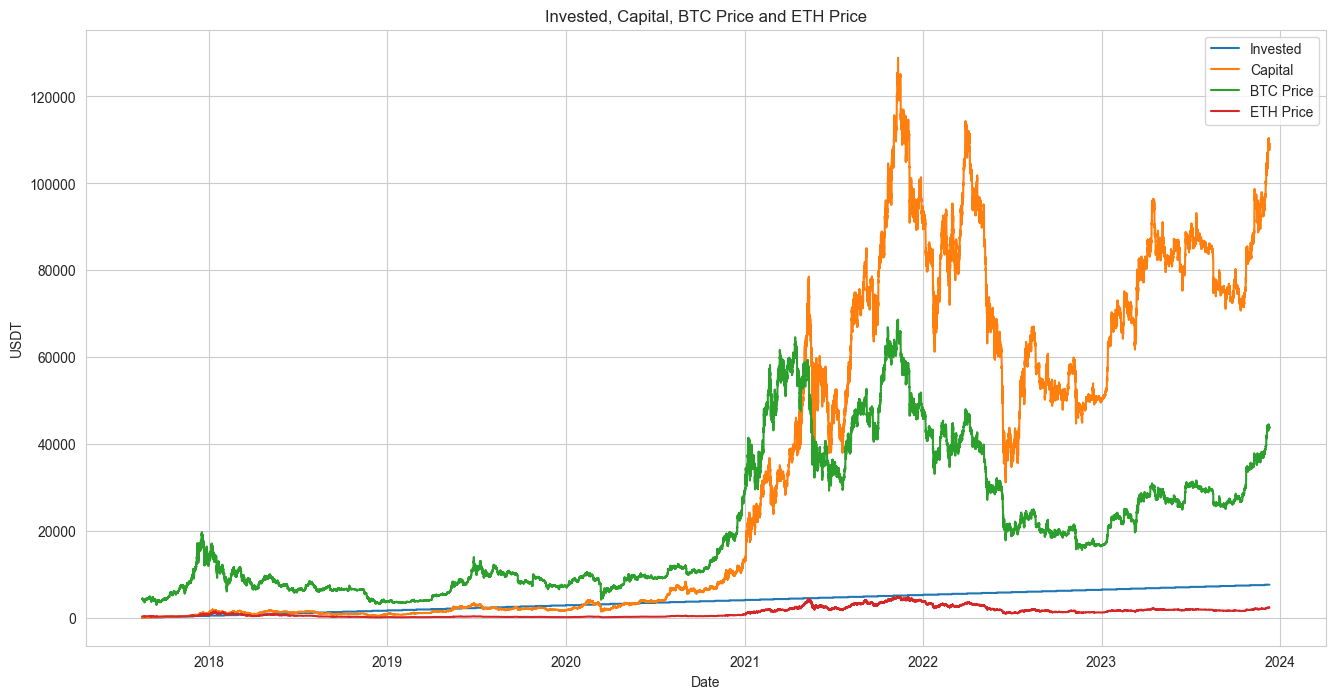

In [100]:
# Let's build a graph on invested, Capital, BTC_Price and ETH_Price
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(data_stat_arb["date"], data_stat_arb["invested"], label="Invested")
ax.plot(data_stat_arb["date"], data_stat_arb["Capital"], label="Capital")
ax.plot(data_stat_arb["date"], data_stat_arb["BTC_Price"], label="BTC Price")
ax.plot(data_stat_arb["date"], data_stat_arb["ETH_Price"], label="ETH Price")

ax.set_title("Invested, Capital, BTC Price and ETH Price")
ax.set_xlabel("Date")
ax.set_ylabel("USDT")
ax.legend()
plt.show()

As we see the strategy is profitable. Let's add it to our dataframe with capital

In [101]:
for i, row in tqdm(every_month_capital.iterrows(), total=every_month_capital.shape[0]):
    date = row["date"]
    capital = data_stat_arb[data_stat_arb["date"] == date]["Capital"].values[0]
    every_month_capital.loc[i, "statistical_arbitrage"] = capital


100%|██████████| 76/76 [00:00<00:00, 2054.10it/s]


In [102]:
every_month_capital.tail()

,date,invested,BTC_Price,buy_and_hold_BTC,buy_and_hold_USDT,mean_reversion,tendency_following,statistical_arbitrage
71,2023-08-01 04:00:00,7200,28866.00,0.667086,19256.094490,3446.813891,9483.274444,84176.992669
72,2023-09-01 04:00:00,7300,26044.46,0.670925,17473.885633,3044.51139,9098.487464,76207.861983
73,2023-10-01 04:00:00,7400,27045.47,0.674623,18245.488510,3395.490859,9323.082707,77472.566062
74,2023-11-01 04:00:00,7500,34439.57,0.677526,23333.716357,3872.008485,12058.318644,83715.027662
75,2023-12-01 04:00:00,7600,38179.86,0.680146,25967.861411,4408.275694,12415.764023,97079.227621


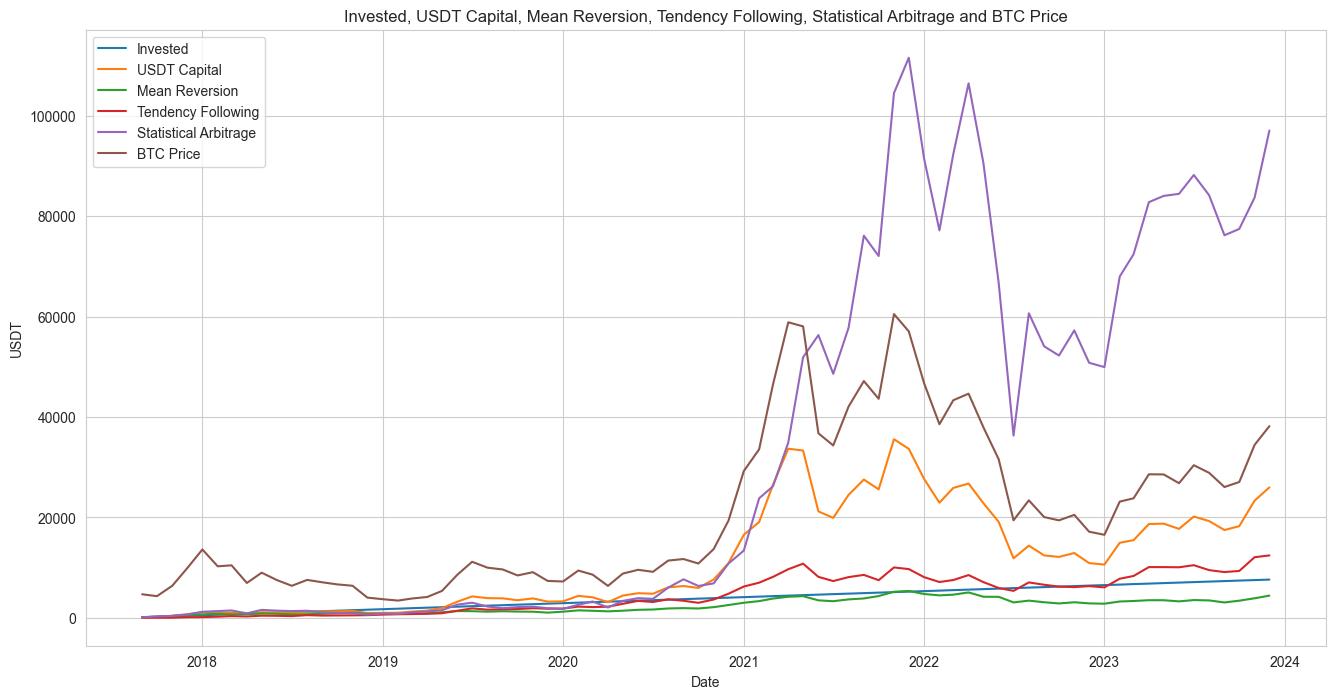

In [103]:
# Let's build a graph on invested, buy_and_hold_USDT, mean_reversion, tendency_following, statistical_arbitrage and BTC_Price

fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(every_month_capital["date"], every_month_capital["invested"], label="Invested")
ax.plot(every_month_capital["date"], every_month_capital["buy_and_hold_USDT"], label="USDT Capital")
ax.plot(every_month_capital["date"], every_month_capital["mean_reversion"], label="Mean Reversion")
ax.plot(every_month_capital["date"], every_month_capital["tendency_following"], label="Tendency Following")
ax.plot(every_month_capital["date"], every_month_capital["statistical_arbitrage"], label="Statistical Arbitrage")
ax.plot(every_month_capital["date"], every_month_capital["BTC_Price"], label="BTC Price")

ax.set_title("Invested, USDT Capital, Mean Reversion, Tendency Following, Statistical Arbitrage and BTC Price")
ax.set_xlabel("Date")
ax.set_ylabel("USDT")
ax.legend()
plt.show()

## Comparison

|                | Invested |  HODL  | Mean Revision | Tendency Folowing | Statistical Arbitrage |
|----------------|:--------:|:------:|:-------------:|:-----------------:|:---------------------:|
| End money      |   7600   |  25967 |      4408     |       12415       |         97079         |
| Capital growth |    +0    | +18367 |     -3192     |       +4815       |         +89479        |
| Percent growth |    +0%   |  +241% |      -42%     |        +63%       |         +1177%        |

And for the end, let's try Statistical Arbitrage on BTCUSDT and ETHUSDT, but only starting from 2022 year, when we know the historical maximum of BTC and ETH prices.

In [113]:
data_stat_arb_2022 = data_stat_arb[data_stat_arb["date"] >= "2022-01-01"]
data_stat_arb_2022.reset_index(drop=True, inplace=True)
# Zero our capitals
data_stat_arb_2022["Money"] = 0
data_stat_arb_2022["BTC"] = 0
data_stat_arb_2022["ETH"] = 0
data_stat_arb_2022["Capital"] = 0

data_stat_arb_2022.head()

,date,invested,BTC_Price,ETH_Price,BTC_Norm,ETH_Norm,Money,BTC,ETH,Capital
0,2022-01-01 00:00:00,5300,46656.13,3723.04,0.679785,0.768158,0,0,0,0
1,2022-01-01 01:00:00,5300,46778.14,3724.89,0.681562,0.768540,0,0,0,0
2,2022-01-01 02:00:00,5300,46811.77,3728.32,0.682052,0.769248,0,0,0,0
3,2022-01-01 03:00:00,5300,46813.20,3723.96,0.682073,0.768348,0,0,0,0
4,2022-01-01 04:00:00,5300,46711.05,3708.21,0.680585,0.765098,0,0,0,0


In [117]:
# Let's start from 1000 USDT and not add money every month
data_stat_arb_2022["invested"] = 1000

In [115]:
# Let's execute our strategy
for i, row in tqdm(data_stat_arb_2022.iterrows(), total=data_stat_arb_2022.shape[0]):
    if i > 0:
        data_stat_arb_2022.loc[i, "Money"] = data_stat_arb_2022.loc[i-1, "Money"]
        data_stat_arb_2022.loc[i, "BTC"] = data_stat_arb_2022.loc[i-1, "BTC"]
        data_stat_arb_2022.loc[i, "ETH"] = data_stat_arb_2022.loc[i-1, "ETH"]
    else:
        data_stat_arb_2022.loc[i, "Money"] = 1000
        data_stat_arb_2022.loc[i, "BTC"] = 0
        data_stat_arb_2022.loc[i, "ETH"] = 0
    
    # Buy BTC and sell ETH if BTC_Norm < ETH_Norm else buy ETH and sell BTC
    if row["BTC_Norm"] > row["ETH_Norm"]:
        if data_stat_arb_2022.loc[i, "BTC"] > 0:
            # Sell BTC
            data_stat_arb_2022.loc[i, "Money"] += data_stat_arb_2022.loc[i, "BTC"] * row["BTC_Price"]
            data_stat_arb_2022.loc[i, "BTC"] = 0
            
        if data_stat_arb_2022.loc[i, "Money"] > 0:
            # Buy ETH
            data_stat_arb_2022.loc[i, "ETH"] += data_stat_arb_2022.loc[i, "Money"] / row["ETH_Price"]
            data_stat_arb_2022.loc[i, "Money"] = 0
    else:
        if data_stat_arb_2022.loc[i, "ETH"] > 0:
            # Sell ETH
            data_stat_arb_2022.loc[i, "Money"] += data_stat_arb_2022.loc[i, "ETH"] * row["ETH_Price"]
            data_stat_arb_2022.loc[i, "ETH"] = 0
        
        if data_stat_arb_2022.loc[i, "Money"] > 0:  
            # Buy BTC
            data_stat_arb_2022.loc[i, "BTC"] += data_stat_arb_2022.loc[i, "Money"] / row["BTC_Price"]
            data_stat_arb_2022.loc[i, "Money"] = 0
            
    data_stat_arb_2022.loc[i, "Capital"] = data_stat_arb_2022.loc[i, "Money"] + data_stat_arb_2022.loc[i, "BTC"] * row["BTC_Price"] + data_stat_arb_2022.loc[i, "ETH"] * row["ETH_Price"]

100%|██████████| 17004/17004 [00:06<00:00, 2666.04it/s]


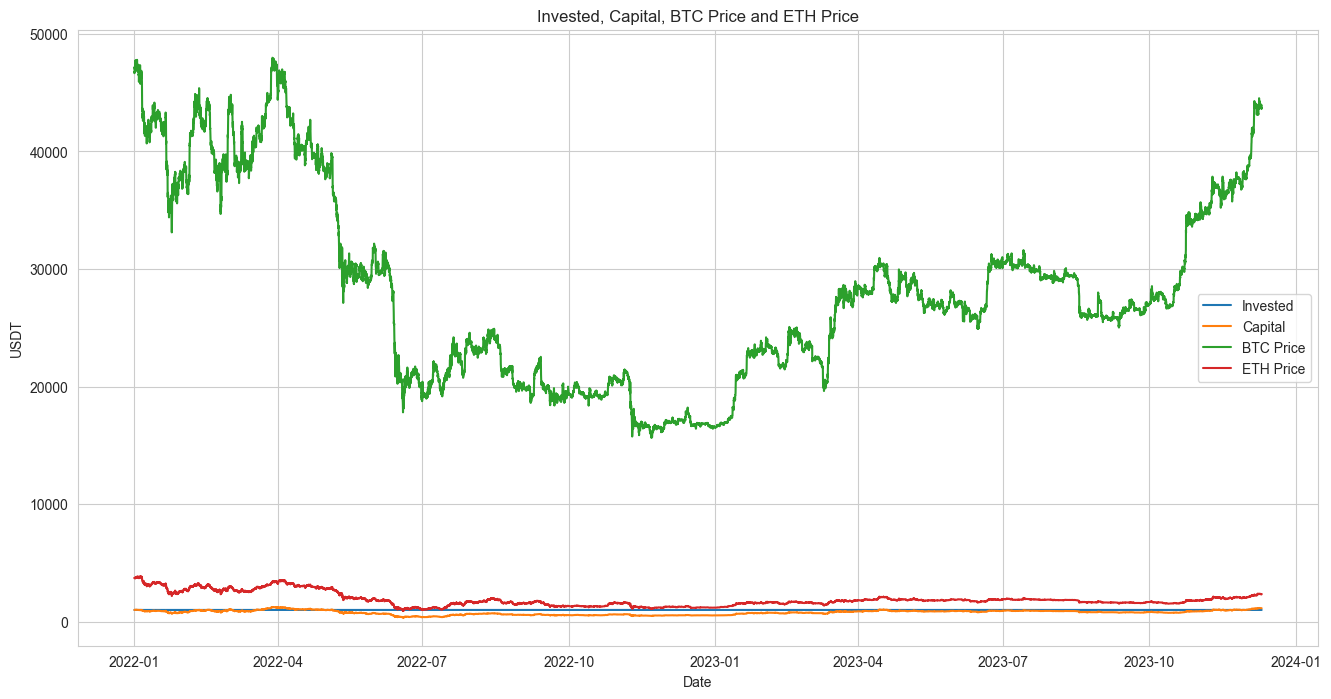

In [118]:
# Let's build a graph on invested, Capital, BTC_Price and ETH_Price
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(data_stat_arb_2022["date"], data_stat_arb_2022["invested"], label="Invested")
ax.plot(data_stat_arb_2022["date"], data_stat_arb_2022["Capital"], label="Capital")
ax.plot(data_stat_arb_2022["date"], data_stat_arb_2022["BTC_Price"], label="BTC Price")
ax.plot(data_stat_arb_2022["date"], data_stat_arb_2022["ETH_Price"], label="ETH Price")

ax.set_title("Invested, Capital, BTC Price and ETH Price")
ax.set_xlabel("Date")
ax.set_ylabel("USDT")
ax.legend()
plt.show()

In [119]:
data_stat_arb_2022.tail()

,date,invested,BTC_Price,ETH_Price,BTC_Norm,ETH_Norm,Money,BTC,ETH,Capital
16999,2023-12-10 08:00:00,1000,43775.51,2343.97,0.637814,0.483621,0.0,0.0,0.490672,1150.119346
17000,2023-12-10 09:00:00,1000,43606.80,2322.62,0.635356,0.479216,0.0,0.0,0.490672,1139.643509
17001,2023-12-10 10:00:00,1000,43700.02,2335.81,0.636714,0.481937,0.0,0.0,0.490672,1146.115466
17002,2023-12-10 11:00:00,1000,43738.02,2337.65,0.637267,0.482317,0.0,0.0,0.490672,1147.018302
17003,2023-12-10 12:00:00,1000,43740.44,2339.02,0.637303,0.482600,0.0,0.0,0.490672,1147.690522


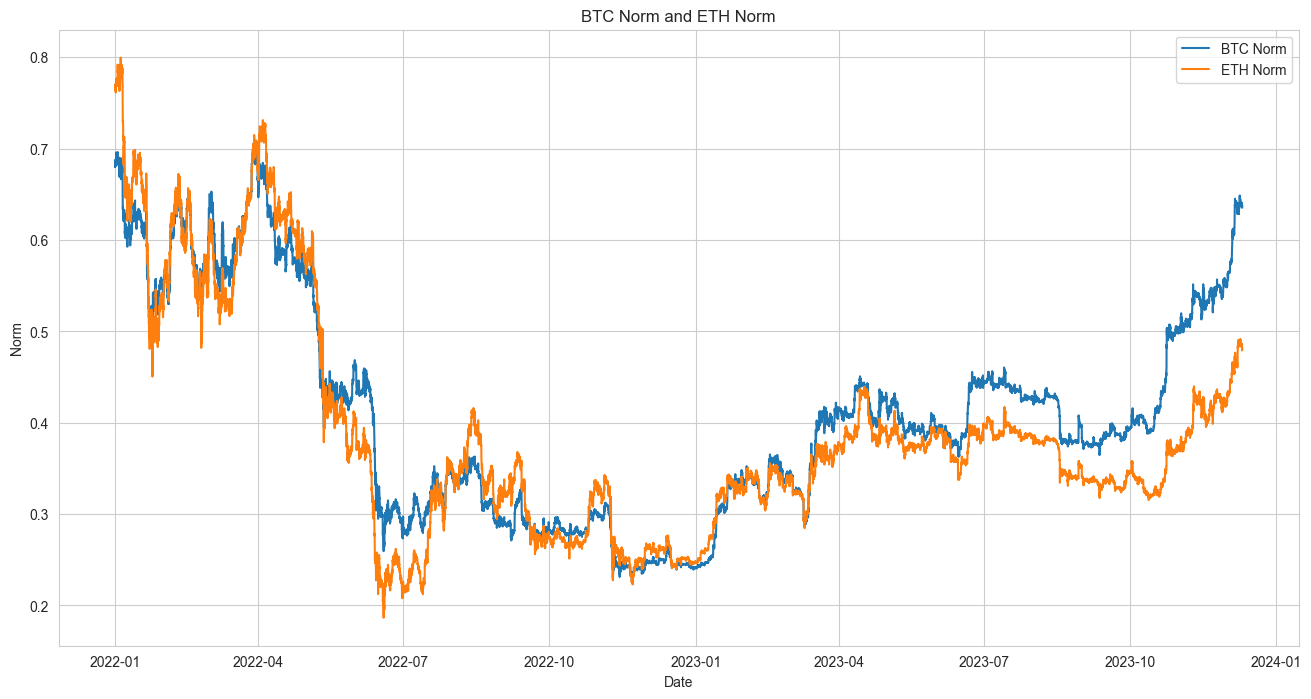

In [121]:
# Let's compare graphics of BTC_Norm and ETH_Norm
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(data_stat_arb_2022["date"], data_stat_arb_2022["BTC_Norm"], label="BTC Norm")
ax.plot(data_stat_arb_2022["date"], data_stat_arb_2022["ETH_Norm"], label="ETH Norm")

ax.set_title("BTC Norm and ETH Norm")
ax.set_xlabel("Date")
ax.set_ylabel("Norm")
ax.legend()
plt.show()

Maybe we had too low crosses on this period and cheat was too big =)